# Microglia Detection Algorithm
## From Kozlowski and Weimer 2012

In this notebook I will try to implement the automated 3D detection algorithm for microglia of [this paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0031814)





In [ ]:
# Load libraries for file handling and image crunching
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import seaborn as sns
# Set matplotlib backend
%matplotlib inline 
import skimage
# Import the os module
import os
# Create an ImageJ2 gateway with the newest available version of ImageJ2.
import imagej
ij = imagej.init()


#testimage = "320774 section 2 image 1 more basal stack.tif (green) MF.tif"
testimage = "322278 cochlea section 1 image 1 more basal stack.tif (green) MF.tif"

testimagebrain = "320763 CNIC.tif"
dirpath = "./"
wdpath = os.getcwd()

filepath = os.path.join(wdpath, testimage)



In [2]:
# load the image
from skimage.io import imread
img = imread(filepath)


For the algorithm we need to have access to the scale of the image to create ROI of specified sizes.
We need to extract the tiff metadata for this.
Try to do this with imageJ API.

In [3]:
import imagej
#import ijfinder
ij = imagej.init('/home/linus/.fiji/Fiji.app')
# this will set the pwd to fiji, change back to the smaple images
os.chdir(wdpath)

In [4]:
# read the image with imagej
img = ij.io().open(filepath)

# the scale is in the coordinate part of this object
img = ij.py.from_java(img)

#extract the number as scalar, is in microns
planestep = float(img['pln'][1].to_numpy())
xystep = float(img['row'][1].to_numpy())

print("xy scale is ", xystep, "micron per pixel")
print("z scale is ", planestep, "micron per pixel")

xy scale is  0.4150000954500219 micron per pixel
z scale is  0.4 micron per pixel


In [5]:
img = img.to_numpy()
img.shape
#dims are z,x,y

(266, 488, 488)

In [6]:
# Now write a function to loock at zstacks for plotting
from ipywidgets import interact

def display_stack(image, step, cmap = "gray"):
    @interact(z=(0,image.shape[0],step))
    def select_z(z=1):
        # slice a plane
        plane = image[z,:,:]
        # Visualization
        plt.figure(figsize=(8,8))
        plt.imshow(plane, interpolation='none', cmap = cmap)
        plt.show()

display_stack(img, step = 2)        

interactive(children=(IntSlider(value=1, description='z', max=266, step=2), Output()), _dom_classes=('widget-i…

## First step of the algorithm: 

Find cell bodies with a local minma/maxima, from the paper:

*First, the positions of individual cells within a field of view were determined by: 1) identifying objects consisting of connected pixels with intensity values above a regional maxima intensity value (imregionalmax function within MATLAB), then 2) calculating the centroid for each object detected with a summed pixel area greater than 50 µm2. Each centroid defined an individual microglia cell positions (CP).*

In [7]:
# make a thing to show 2 image side by side
def display_stack2(image1, image2, step, cmap1 = "gray", cmap2 = "gray"):
    @interact(z=(0,image1.shape[0],step))
    def select_z(z=1):
        # slice a plane
        plane1 = image1[z,:,:]
        plane2 = image2[z,:,:]
        # Visualization
        fig, ax = plt.subplots(1, 2, figsize=(10,7))
        
             
        ax[0].imshow(plane1, interpolation='none', cmap = cmap1)
        ax[1].imshow(plane2, interpolation='none', cmap = cmap2)
        
        plt.show()
        
        
# Now write a function to layer z stacks over each other
def display_stack_layered(image1, image2, step, cmap1 = "gray", cmap2 = "gray"):
    @interact(z=(0,image1.shape[0],step))
    def select_z(z=1):
        # slice a plane
        plane1 = image1[z,:,:]
        plane2 = image2[z,:,:]
        # Visualization      
        plt.figure(figsize =[10, 10])
     
        plt.imshow(plane1, interpolation='none', cmap = cmap1)
        plt.imshow(plane2, interpolation='none', cmap = cmap2)
        
        plt.show()

In [8]:
# before putting this through run a blur
filtered = ndi.filters.gaussian_filter(img, 4)
display_stack2(img, filtered, step =3)

interactive(children=(IntSlider(value=1, description='z', max=266, step=3), Output()), _dom_classes=('widget-i…

In [79]:
# define a cube of x microns as a footprint
# use the scale and floor division to find the number of pixels in each dimension to use
x = 30
foot = np.ones((int(x//planestep),
               int(x//xystep),
               int(x//xystep)))

# run the maxima detection
from skimage.feature import peak_local_max
locmax = peak_local_max(filtered, min_distance=0, footprint = foot)

# create an empty boolean array of the dimensions of the source
localhigh = np.zeros_like(filtered, dtype=bool)
# dont understand this bit but it will feed the coord to the empty mask
localhigh[tuple(locmax.T)] = True

In [94]:
# show the regional max pixels

#do an expand for plotting and label
from skimage.segmentation import expand_labels
seed_label = ndi.label(localhigh)[0]
localhighplot = expand_labels(seed_label,10)

localhighplot = np.ma.array(localhighplot, mask = localhighplot == 0)

display_stack_layered(img, localhighplot, cmap2 = "prism", step =2)

interactive(children=(IntSlider(value=1, description='z', max=266, step=2), Output()), _dom_classes=('widget-i…

Next steps: filter object smaller than 50 microns squared.
I dont know how well this will work here as the labelling is Iba and not gfp.
I got plenty of very small seeds.
Calculate the area of every seed and make a histogram.

## Alternatively  I
use the h-maxima function that should handle noisy input better.
Code below is very slow, not feasible.

In [13]:
#from skimage.morphology import extrema
#foot_uneven = np.ones((int(x//planestep-1),
 #              int(x//xystep-1),
#               int(x//xystep)-1))
#h = 100
#h_maxima = extrema.h_maxima(img, h, selem = foot_uneven)
# update selem to footprint for skimage >0.19
#label_h_maxima = label(h_maxima)

## Alternatively II
Use a blob detecting routine, check documentation [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html)

In [73]:
from skimage.feature import blob_dog, blob_log, blob_doh
# this will take a long time
#blobs = blob_dog(img)

In [74]:
blobs
#also finds no blobs whatsoever

array([], shape=(0, 3), dtype=float64)

## Proceed with the seeds

In [167]:
# start the loop
import pandas as pd
seedresultlist = []

# use this object to get all out
seedprops = skimage.measure.regionprops(label_image = seed_label, intensity_image =  img)


for seed in np.unique(seed_label[0]):
#for seed in range(10):
    # subset the seed array to the loop cell
    loopseed = seed_label == seed    
    loopdata = img[loopseed]
        
    result = {'ID' : seed,
              'npix': np.size(loopdata),
             'cell_int': np.mean(loopdata)}
    #print(result)
    seedresultlist.append(result)

<AxesSubplot:xlabel='npix', ylabel='Count'>

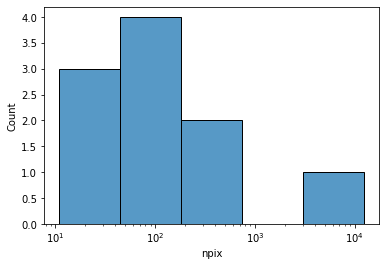

In [96]:
df = pd.DataFrame(seedresultlist).query('ID != 0')

sns.histplot(df['npix'], log_scale = True)

For a start, do not filter any seeds, go to next step, calculate centroid.

In [105]:
seedprops = skimage.measure.regionprops(label_image = seed_label, intensity_image =  img)
  
centroid_df = pd.DataFrame(skimage.measure.regionprops_table(label_image = seed_label, intensity_image =  img, properties = ('label', 'centroid')))

# extract the centroids to a numpy array of coordinates
centroid_array = centroid_df.to_numpy()[:, 1:4]
# round the coordinates to integers (pixel coords)
centroid_array = centroid_array.astype("int")

centroid_img = np.zeros_like(img, dtype=bool)
# This will feed the coord to the empty mask
centroid_img[tuple(centroid_array.T)] = True

# label the centroids                                                 
centroid_img = ndi.label(centroid_img)[0]
# expand to a couple of pixels
centroid_img = expand_labels(centroid_img,10)

centroid_img_nobg = np.ma.array(centroid_img, mask = centroid_img == 0)

# plot
display_stack_layered(img,centroid_img_nobg, cmap2 = "prism", step = 2)

interactive(children=(IntSlider(value=1, description='z', max=266, step=2), Output()), _dom_classes=('widget-i…

Next, generate ROI of 120x120x120 microns centered at a centroid pixel.

In [106]:
# make some more convenience functions for plotting
# subset a stack and make projections
def project_stack_10(stack):
    tilelist = []   
    for i in range(1,11):
        # number of slices 
        nslice = stack.shape[0]
        # subset the slices of the loop
        nslice_loop = stack.shape[0]//10
        startslice = (i-1) * nslice_loop
        endslice = i*nslice_loop-1
        #print(startslice, endslice)
        
        #subset the image
        loopimg = stack[startslice:endslice,:,:]
        # calculate a maximum intesity prjection
        projection = np.max(loopimg, axis=0)
        tilelist.append(projection)
    return tilelist
 

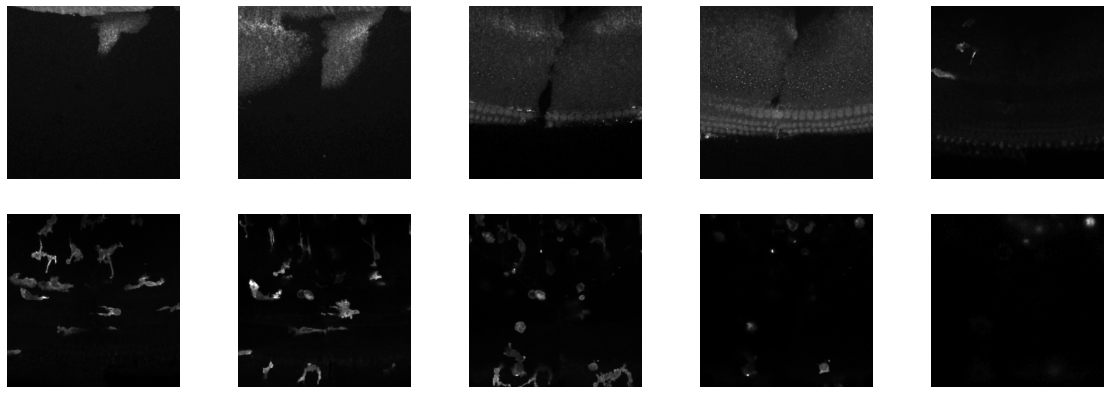

In [107]:
def plot_ztile10(image, cmap = "gray"):
    tiledimage = project_stack_10(image)
    plt.figure(figsize=(20,7))
    for num, x in enumerate(tiledimage):
        loopimg = tiledimage[num]
        plt.subplot(2,5,num+1)
        plt.axis('off')
        plt.imshow(loopimg, cmap = cmap)    

        
plot_ztile10(img)    

In [108]:
# write this for an image + annotation layer array
def plot_ztile10_layered(image, annot, cmap1 = "gray", cmap2 = "prism"):
    tiledimage = project_stack_10(image)
    tiledannot = project_stack_10(annot)
    
    plt.figure(figsize=(20,7))
    for num, x in enumerate(tiledimage):
        loopimg = tiledimage[num]
        loopannot = tiledannot[num]
        
        plt.subplot(2,5,num+1)
        plt.axis('off')
        plt.imshow(loopimg, cmap = cmap1)
        plt.imshow(loopannot, cmap = cmap2, alpha = 0.5)

        


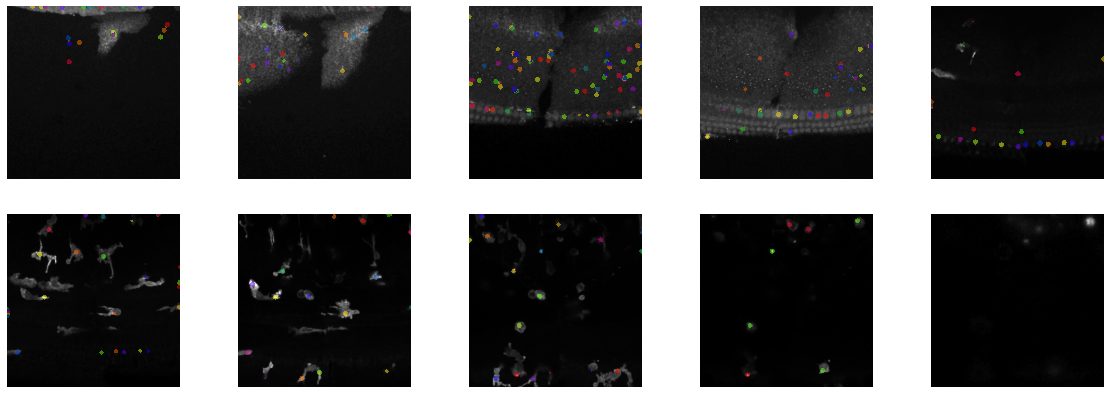

In [109]:
plot_ztile10_layered(img, centroid_img_nobg)

## Iterate over candidate cell positions



In [110]:
# refresh the centroid data to get the one pixel values for processing rather than plotting
centroid_array = centroid_df.to_numpy()[:, 1:4]
# round the coordinates to integers (pixel coords)
centroid_array = centroid_array.astype("int")

centroid_img = np.zeros_like(img, dtype=bool)
# label the centroids
centroid_img = ndi.label(centroid_img)[0]


In [119]:
#Iterating the dataset would take a long time, sample some for a start
#cellsample = np.random.choice(np.unique(centroid_img),50)
#iterate over the cells

# make an array with just one cell in it
i = np.random.choice(np.unique(centroid_img),1)
loopcentroid = centroid_img == i

from skimage.segmentation import expand_labels
from skimage.filters import threshold_otsu
loopROI = expand_labels(loopcentroid,50)

loopimg = img*loopROI
# do otsu thresh on image
loopimg_bin = loopimg < threshold_otsu(loopimg)

In [121]:
# watershed fill the cellof Interest
from skimage.morphology import watershed
candidatemask = watershed(loopimg_bin, loopcentroid)

/home/linus/anaconda3/envs/analysis/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [122]:
def mask_bg(binimage):
    mask = np.ma.array(binimage, mask = binimage == 0)
    return mask

In [124]:
display_stack2(loopimg, mask_bg(candidatemask), step=2, cmap2 = "viridis")

interactive(children=(IntSlider(value=1, description='z', max=266, step=2), Output()), _dom_classes=('widget-i…

This is slow because it runs on (basically) the whole image everytime. Do it at once instead. Try global Thresholding algos first.

In [138]:
import skimage.filters
t_otsu = img > skimage.filters.threshold_otsu(img)
t_tri = img > skimage.filters.threshold_triangle(img)
t_ni = img > skimage.filters.threshold_niblack(img)

In [139]:
t_yen = img > skimage.filters.threshold_yen(img)

In [140]:
display_stack2(t_tri, mask_bg(centroid_img_nobg), step=2, cmap2 = "viridis")

interactive(children=(IntSlider(value=1, description='z', max=266, step=2), Output()), _dom_classes=('widget-i…

Triangle and Otsu perform well. Take the whole binarised image, and watershed fill from the seeds.

In [152]:
display_stack2(~t_otsu, mask_bg(candidatecell), step=2, cmap2 = "prism")

interactive(children=(IntSlider(value=1, description='z', max=266, step=2), Output()), _dom_classes=('widget-i…

Actually, that looks good enough to just start the labelling from the Otsu image.

In [153]:
cand_cells = ndi.label(t_otsu)

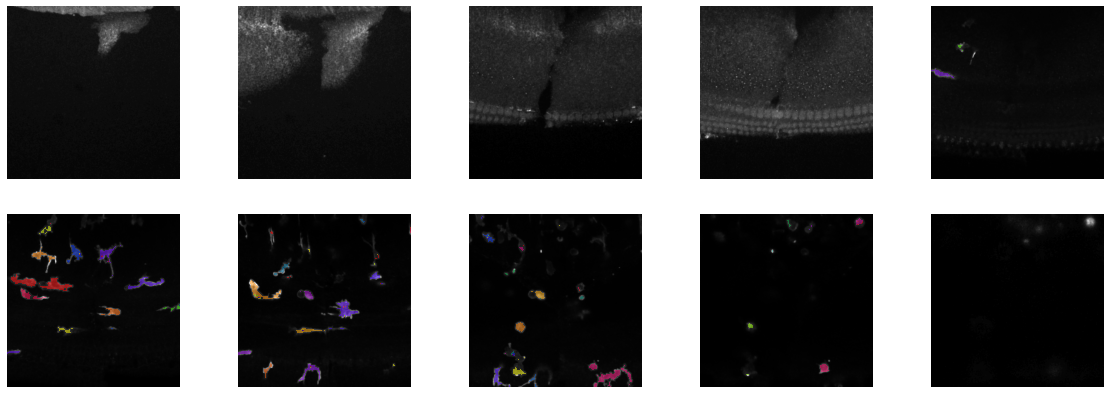

In [155]:
plot_ztile10_layered(img, mask_bg(cand_cells[0]))

In [156]:
display_stack_layered(img, mask_bg(cand_cells[0]), cmap2 = "prism", step = 2)

interactive(children=(IntSlider(value=1, description='z', max=266, step=2), Output()), _dom_classes=('widget-i…

In [178]:
# do the stats
cellresultlist = []

# use this object to get all out
cellprops = skimage.measure.regionprops(label_image = cand_cells[0], intensity_image =  img)

for cell in np.unique(cand_cells[0]):
#for seed in range(10):
    # subset the seed array to the loop cell
    loopcell = cand_cells[0] == cell    
    loopdata = img[loopcell]
        
    result = {'ID' : cell,
              'npix': float(np.size(loopdata))}
    #print(result)
    cellresultlist.append(result)

In [194]:
df = pd.DataFrame(cellresultlist).query('npix > 2')

<AxesSubplot:xlabel='npix', ylabel='Count'>

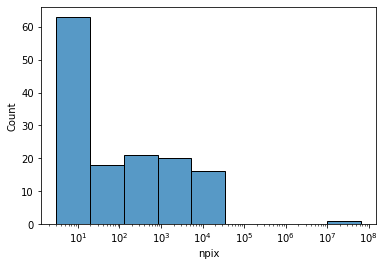

In [195]:
sns.histplot(df['npix'], log_scale = True)

In [206]:
# remove all candidate cell seeds smaller than 2 pixels
cellcentroid_df = pd.DataFrame(skimage.measure.regionprops_table(label_image = cand_cells[0],
                                                                 intensity_image =  img,
                                                                 properties = ('label', 'centroid', 'area')))


In [207]:
cellcentroid_df.query('area > 2')

,label,centroid-0,centroid-1,centroid-2,area
3,4,45.714286,57.428571,65.285714,7
5,6,48.000000,57.500000,74.500000,4
6,7,50.000000,57.800000,117.400000,5
12,13,55.200000,271.400000,9.800000,5
15,16,68.250000,293.000000,139.750000,4
...,...,...,...,...,...
374,375,219.000000,25.500000,459.500000,4
376,377,219.391304,35.434783,304.608696,23
384,385,224.048544,77.148867,267.090615,309
387,388,222.222222,40.888889,303.555556,9


In [214]:
# extract the centroids to a numpy array of coordinates
centroid_array = cellcentroid_df.to_numpy()[:, 1:4]
# round the coordinates to integers (pixel coords)
centroid_array = centroid_array.astype("int")

centroid_img = np.zeros_like(img, dtype=bool)
# This will feed the coord to the empty mask
centroid_img[tuple(centroid_array.T)] = True

#
# expand to a couple of pixels (they will flow together)
centroid_img = expand_labels(centroid_img,15)
# label the centroids                                                 
centroid_img = ndi.label(centroid_img)[0]

In [215]:
display_stack_layered(img, mask_bg(centroid_img), cmap2 = "prism", step = 2)

interactive(children=(IntSlider(value=1, description='z', max=266, step=2), Output()), _dom_classes=('widget-i…